In [413]:
from pathlib import Path
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization, Dense, Input, Conv1D, Add, ELU, Flatten, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, Softmax, Concatenate, Reshape, Multiply, ReLU, Dropout
from keras.optimizers import SGD
from keras import activations
from keras import Model
from keras.initializers import HeNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from load_dataset import load_original_daic, load_labels
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model

In [414]:
daic_pose_train = load_original_daic("original_daic/train", "pose")
daic_pose_dev = load_original_daic("original_daic/dev", "pose")
daic_pose_test = load_original_daic("original_daic/test", "pose")

In [415]:
# daic_pose_dev["432"].loc[0:4999]
# for i in range(5000):
#     try:
#         temp = daic_pose_test["432"].loc[i].to_numpy(dtype="float32")
#     except Exception:
#         print(i)

In [416]:
label_path = Path("original_daic/labels")
loaded_labels = load_labels(label_path)
y_train = np.array(loaded_labels["train"])
y_dev = np.array(loaded_labels["dev"])
y_test = np.array(loaded_labels["test"])


In [417]:
# train_depressed_idx = np.where(y_train==1)[0]
# dev_depressed_idx = np.where(y_dev==1)[0]
# test_depressed_idx = np.where(y_test==1)[0]

In [418]:
pose_train = []
pose_dev = []
pose_test = []
for subject_id, subject_df in daic_pose_train.items():
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_train.append(temp)
for subject_id, subject_df in daic_pose_dev.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_dev.append(temp)
for subject_id, subject_df in daic_pose_test.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_test.append(temp)

In [419]:
# list1 = [np.array([12,1]), np.array([2,3])]
# list2 = [np.array([4,5]), np.array([6,7])]
# list3 = [np.array([8,9]), np.array([10,11])]
# all_lists = np.array(list1 + list2 + list3)
# print(all_lists.min(0))
# print(all_lists.ptp(0))
all_samples = pose_train + pose_dev + pose_test
# all_samples = np.array(pose_train + pose_dev + pose_test, dtype=object)
all_samples = np.concatenate((all_samples),)
# all_samples.shape
min_values = all_samples.min(axis=0)
ptp_ranges = all_samples.ptp(axis=0)

In [420]:
pose_train = np.array(pose_train)
pose_dev = np.array(pose_dev)
pose_test = np.array(pose_test)

In [421]:
norm_pose_train = (pose_train - min_values)/ptp_ranges
norm_pose_dev = (pose_dev - min_values)/ptp_ranges
norm_pose_test = (pose_test - min_values)/ptp_ranges

In [422]:
print(y_test.shape)
print(sum(y_train))

(47,)
30


In [423]:
# depressed_only = norm_pose_train[train_depressed_idx]
indices = range(norm_pose_train.shape[0])
oversample = RandomOverSampler(sampling_strategy='minority')
# oversample = RandomOverSampler(sampling_strategy=0.75)
# print(norm_pose_train[:].shape)
indices = np.array(indices).reshape(-1,1)
ros_indices, _ = oversample.fit_resample(indices, y_train)
print(len(ros_indices))
rng = np.random.default_rng(10000)
rng.shuffle(ros_indices)
ros_norm_pose_train = np.squeeze(norm_pose_train[ros_indices])
over_train_y = np.squeeze(y_train[ros_indices])
# print(ros_norm_pose_train.shape)

154


In [424]:
print(over_train_y)

[0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1
 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1
 1 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0
 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1
 0 1 0 1 1 1]


In [425]:
input_pose = Input(shape=[5000, 6])
tdcn_dim_pose = [128,64,256,128,64] # used in Guo's paper
# tdcn_dim_pose = [128,128,128,128,128]
bias_initializer = HeNormal(seed=0)

In [426]:
x_train_bad = np.concatenate((np.zeros((200, 5000, 6)), np.ones((200, 5000, 6))))
y_train_bad = np.concatenate((np.zeros(200), np.ones(200)))
x_dev_bad = np.concatenate((np.zeros((20, 5000, 6)), np.ones((20, 5000, 6))))
y_dev_bad = np.concatenate((np.zeros(20), np.ones(20)))
rng = np.random.default_rng(12345)
order = np.arange(0,400)
rng.shuffle(order)
x_train_bad = x_train_bad[order]
y_train_bad = y_train_bad[order]
print(x_train_bad.shape)
print(y_train_bad.shape)

(400, 5000, 6)
(400,)


In [427]:
# One DCB
# first layer of the DCB
def diluted_conv_block(inputs, feature_dim, batch_normalisation=False):
    # with K.name_scope(block_name)
    l1_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_add = Add()([l1_p1, l1_p2])
    l1_ELU = ELU()(l1_add)
    # second layer of the DCB
    # l2_p1 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    # l2_p2 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_add = Add()([l2_p1, l2_p2])
    l2_ELU = ELU()(l2_add)
    # third layer of the DCB
    # l3_p1 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    # l3_p2 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_add = Add()([l3_p1, l3_p2])
    l3_ELU = ELU()(l3_add)

    residual = Conv1D(filters=feature_dim, kernel_size=1, padding="same")(inputs)
    res_add = Add()([l3_ELU, residual])
    if batch_normalisation:
        bn = BatchNormalization()(res_add)
        return bn
    else:
        return res_add

In [428]:
def time_diluted_conv_net(feature_dim, input_layer, pool_size, pool_stride):
    dcb_1 = diluted_conv_block(input_layer, feature_dim[0], batch_normalisation=True)
    mp_1 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_1)
    dcb_2 = diluted_conv_block(mp_1, feature_dim[1], batch_normalisation=True)
    mp_2 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_2)
    dcb_3 = diluted_conv_block(mp_2, feature_dim[2], batch_normalisation=True)
    mp_3 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_3)
    dcb_4 = diluted_conv_block(mp_3, feature_dim[3], batch_normalisation=True)
    mp_4 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_4)
    dcb_5 = diluted_conv_block(mp_4, feature_dim[4], batch_normalisation=False)
    return dcb_5
    # return dcb_2

# TDCN block for pose
tdcn_pose = time_diluted_conv_net(
    feature_dim = tdcn_dim_pose, 
    input_layer = input_pose, 
    pool_size = 2, 
    pool_stride = 2,
    )

# FWA block
concat_layer = Concatenate()([tdcn_pose])
# print(concat_layer.shape)
# gap_layer = GlobalAveragePooling1D(data_format="channels_last")(concat_layer)
gap_layer = GlobalAveragePooling1D(data_format="channels_last")(tdcn_pose)
# print(gap_layer.shape)

linear_layer_1 = Dense(gap_layer.shape[1])(gap_layer)
# relu_layer = Dense(128, activation = "relu")(linear_layer_1)
relu_layer = activations.relu(linear_layer_1)
# relu_layer = ReLU()(linear_layer_1)
linear_layer_2 = Dense(gap_layer.shape[1])(relu_layer)
# sigmoid_layer = Dense(128, activation = "sigmoid")(linear_layer_2)
sigmoid_layer = activations.sigmoid(linear_layer_2)
# reshape_layer = Reshape((312, 128),)(sigmoid_layer)
# print(reshape_layer.output_shape)
# elementwise_product = Multiply()([concat_layer, reshape_layer])
# elementwise_product = Multiply()([concat_layer, sigmoid_layer])
elementwise_product = Multiply()([tdcn_pose, sigmoid_layer])
print(elementwise_product.shape)
# FC layer
flatten = Flatten()(elementwise_product)
print(flatten.shape)
# the default (but should it be?)
# FC_l1 = Dense(16, activation="relu")(flatten)
# FC_l2 = Dense(12, activation="relu")(FC_l1)
# FC_l3 = Dense(8, activation="relu")(FC_l2)
# last_layer = Dense(2, activation="relu")(FC_l3)

# FC_l1 = Dense(64, activation="relu")(flatten)
# FC_l2 = Dense(32, activation="relu")(FC_l1)
# FC_l3 = Dense(16, activation="relu")(FC_l2)
# last_layer = Dense(2, activation="relu")(FC_l3)

FC_l1 = Dense(15000)(flatten)
FC_l2 = Dense(9000)(FC_l1)
# FC_l3 = Dense(320, activation="relu")(FC_l2)
# FC_l4 = Dense(80, activation="relu")(FC_l3)
last_layer = Dense(2)(FC_l2)

# FC_l1 = Dense(16, activation="relu")(flatten)
# drop_1 = Dropout(0.2)(FC_l1)
# FC_l2 = Dense(16, activation="relu")(drop_1)
# drop_2 = Dropout(0.2)(FC_l2)
# FC_l3 = Dense(8, activation="relu")(drop_2)
# drop_3 = Dropout(0.2)(FC_l3)
# last_layer = Dense(2, activation="relu")(drop_3)

# FC_l1 = Dense(100, activation="relu")(flatten)
# FC_l2 = Dense(15, activation="relu")(FC_l1)
# # FC_l3 = Dense(30, activation="relu")(FC_l2)
# last_layer = Dense(2, activation="relu")(FC_l2)

output = Softmax()(last_layer)
# output = Dense(1, activation = "sigmoid")(FC_l3)

(None, 312, 64)
(None, 19968)


In [429]:
batch_size = 8
checkpoint_path = "training_ckpts/keras/pose/pose_training_E-{epoch:04d}.ckpt"
checkpoint_dir = Path(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_dir, save_weights_only=True, save_freq=5*batch_size, verbose=1)

In [430]:
model_pose = Model(inputs=[input_pose], outputs=[output])

In [431]:
# model_pose = load_model("saved_models/good_pose_5_7")

In [432]:
# in this instance was using kernel_size=3 for all conv layers and 16,12,8,2 for the FC layers
# model_pose.load_weights("training_ckpts\pose_training_C2-0005.ckpt")

In [433]:
opt = SGD(learning_rate = 2e-5, momentum = 0.9)
# opt = SGD(learning_rate = 2e-5, momentum = 0.9, nesterov=True)
# opt = SGD(learning_rate = 2e-6, momentum = 0.05)
model_pose.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])
# model_pose.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
# model_pose.save_weights(checkpoint_path.format(epoch=0))

In [434]:
# model_pose.fit(x_train_bad[:], y_train_bad[:], validation_data=(x_dev_bad[:], y_dev_bad[:]), epochs=4)
# model_pose.fit(norm_pose_train[:], y_train[:], validation_data=(norm_pose_dev[:], y_dev[:]), epochs=6, batch_size=8)
model_pose.fit(ros_norm_pose_train[:], over_train_y, validation_data=(norm_pose_dev[:], y_dev[:]), epochs=20, batch_size=batch_size, callbacks=[cp_callback])
# model_pose.fit(ros_norm_pose_train[:], over_train_y, validation_data=(norm_pose_dev[:], y_dev[:]), epochs=4, callbacks=[cp_callback])
# model_pose.fit(ros_norm_pose_train[:], over_train_y, validation_data=(norm_pose_dev[:], y_dev[:]), epochs=10, batch_size=batch_size)

Epoch 1/20
20/20 [==============================] - 82s 4s/step - loss: 0.9790 - accuracy: 0.4221 - val_loss: 1.0612 - val_accuracy: 0.6571
Epoch 2/20
19/20 [===========================>..] - ETA: 3s - loss: 0.8615 - accuracy: 0.4539
Epoch 2: saving model to training_ckpts\pose_training_D-0002.ckpt
20/20 [==============================] - 91s 5s/step - loss: 0.8595 - accuracy: 0.4545 - val_loss: 0.7903 - val_accuracy: 0.6571
Epoch 3/20
20/20 [==============================] - 71s 4s/step - loss: 0.7931 - accuracy: 0.5844 - val_loss: 0.7206 - val_accuracy: 0.6571
Epoch 4/20
19/20 [===========================>..] - ETA: 3s - loss: 0.7748 - accuracy: 0.4145
Epoch 4: saving model to training_ckpts\pose_training_D-0004.ckpt
20/20 [==============================] - 88s 4s/step - loss: 0.7797 - accuracy: 0.4156 - val_loss: 0.7560 - val_accuracy: 0.6571
Epoch 5/20
20/20 [==============================] - 72s 4s/step - loss: 0.7778 - accuracy: 0.4935 - val_loss: 1.0764 - val_accuracy: 0.6571
Ep

KeyboardInterrupt: 

In [ ]:
# model_pose.evaluate(x=pose_test, y=y_test)
print(sum(over_train_y)/len(over_train_y))
print(sum(y_train)/len(y_train))
print(sum(y_dev)/len(y_dev))
print(sum(y_test)/len(y_test))

0.5
0.2803738317757009
0.34285714285714286
0.2978723404255319


2/2 [==============================] - 2s 302ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[0.         0.65714286]
 [0.         0.34285714]]


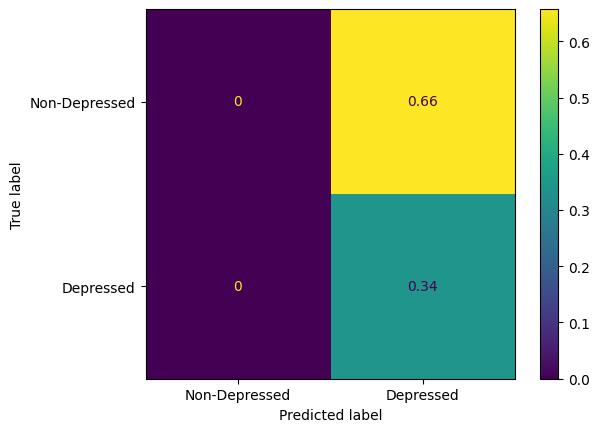

Accuracy = 0.34285714285714286
Recall = 1.0
Precision = 0.34285714285714286
F1-score = 0.5106382978723404


In [ ]:
#Predict
# x = norm_pose_train
# y = y_train
x = norm_pose_dev
y = y_dev
# x = x_dev_bad
# y = y_dev_bad
y_pose_prediction = model_pose.predict(x)
y_pose_prediction = np.argmax(y_pose_prediction, axis = 1)

# where_0 = np.where(y_pose_prediction == 0)
# where_1 = np.where(y_pose_prediction == 1)
# y_pose_prediction[where_0] = 1
# y_pose_prediction[where_1] = 0

# print(sum(y_pose_prediction)/len(y_pose_prediction))
print(y_pose_prediction)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y, y_pose_prediction, normalize='pred')
print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["Non-Depressed", "Depressed"])
cm_display.plot()
plt.show()
tn_pose = result[0][0]
tp_pose = result[1][1]
fn_pose = result[1][0]
fp_pose = result[0][1]
accuracy = (tp_pose + tn_pose)/(tp_pose + tn_pose + fp_pose + fn_pose)
recall = tp_pose / (tp_pose + fn_pose)
precision = tp_pose / (tp_pose + fp_pose)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

In [ ]:
# model_pose.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 5000, 6)]    0           []                               
                                                                                                  
 conv1d_1225 (Conv1D)           (None, 5000, 128)    2432        ['input_10[0][0]']               
                                                                                                  
 conv1d_1226 (Conv1D)           (None, 5000, 128)    2432        ['input_10[0][0]']               
                                                                                                  
 add_700 (Add)                  (None, 5000, 128)    0           ['conv1d_1225[0][0]',            
                                                                  'conv1d_1226[0][0]']     

In [ ]:
plot_model(model_pose, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# model_pose.save("saved_models/pose_madeupdata_20_7")